In [1]:
import wilds
print(wilds.__version__)
from wilds.datasets.camelyon17_dataset import Camelyon17Dataset
from wilds.datasets.civilcomments_dataset import CivilCommentsDataset
from torchvision.transforms import Compose, ToTensor, Resize
from tqdm.auto import tqdm

2.0.0


## Camelyon17

In [3]:
dataset = Camelyon17Dataset(root_dir='/voyager/datasets', download=True)

In [4]:
""" For Bayesian D-PDDM
- train         (used to train base model)
- valid         (used ot validate base model)
- dpddm_train   (used to train dpddm's Phi)
- dpddm_id      (used to validate FPR)
- dpddm_ood     (used to validate TPR)
"""

splits = {
    'train': 'train',
    'valid': 'val',
    'dpddm_train': 'id_val',
    'dpddm_id': 'val',
    'dpddm_ood': 'test'
}

In [7]:
for split in splits.keys():
    try: 
        ds = dataset.get_subset(splits[split], transform=Compose([Resize((224, 224)), ToTensor()]))
        print(split, len(ds))
    except:
        continue

train 302436
valid 34904
dpddm_train 33560
dpddm_id 34904
dpddm_ood 85054


In [8]:
ds = dataset.get_subset(splits['train'], transform=Compose([Resize((224, 224)), ToTensor()]))

In [ ]:
import torch
import torch.nn as nn
import torch.optim as optim
from torchvision.models import resnet50
from wilds.datasets.camelyon17_dataset import Camelyon17Dataset
from torch.utils.data import DataLoader
from torchvision import transforms
from tqdm import tqdm
import wandb 

run = wandb.init(
    # Set the wandb entity where your project will be logged (generally your team name).
    entity="opent03-team",
    # Set the wandb project where this run will be logged.
    project="wilds_dpddm",
    # Track hyperparameters and run metadata.
    config={
        "learning_rate": 0.001,
        "architecture": "resnet18",
        "dataset": "Camelyon17",
        "epochs": 50,
    },
)


# Set device
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

# Initialize WILDS dataset
dataset = Camelyon17Dataset(root_dir='/h/300/viet/bayesian_dpddm/data', download=True)

# Get train, validation, and test sets
train_data = dataset.get_subset('train', frac=0.1)
val_data = dataset.get_subset('val',  frac=0.1)
test_data = dataset.get_subset('test',  frac=0.1)

train_transform = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.RandomHorizontalFlip(p=0.5),
    transforms.RandomVerticalFlip(p=0.5),
    transforms.RandomRotation(degrees=90),
    transforms.ColorJitter(brightness=0.1, contrast=0.1, saturation=0.1, hue=0.05),
    transforms.RandomAffine(degrees=0, translate=(0.1, 0.1)),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
])

# For validation/test (no augmentations)
val_transform = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
])

# Apply transformations
train_data.transform = train_transform
val_data.transform = val_transform
test_data.transform = val_transform

# Create data loaders
batch_size = 32
train_loader = DataLoader(train_data, batch_size=batch_size, shuffle=True, num_workers=4, pin_memory=True)
val_loader = DataLoader(val_data, batch_size=batch_size, num_workers=4, pin_memory=True)
test_loader = DataLoader(test_data, batch_size=batch_size, num_workers=4, pin_memory=True)

# Initialize ResNet18
model = resnet50(pretrained=False)  # Using pretrained weights

# Modify the final layer for binary classification (tumor vs normal)
num_features = model.fc.in_features
model.fc = nn.Linear(num_features, 2)  # Camelyon17 has 2 classes

model = model.to(device)

# Loss function and optimizer
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)

# Training loop
num_epochs = 10

for epoch in range(num_epochs):
    model.train()
    running_loss = 0.0
    correct = 0
    total = 0
    
    # Training phase
    for batch in tqdm(train_loader, desc=f'Epoch {epoch+1}/{num_epochs}'):
        x, y, metadata = batch
        x, y = x.to(device), y.to(device)
        
        optimizer.zero_grad()
        outputs = model(x)
        loss = criterion(outputs, y)
        loss.backward()
        optimizer.step()
        
        running_loss += loss.item()
        _, predicted = torch.max(outputs.data, 1)
        total += y.size(0)
        correct += (predicted == y).sum().item()
    
    train_loss = running_loss / len(train_loader)
    train_acc = 100 * correct / total
    
    wandb.log({
        'train_loss': train_loss,
        'train_acc': train_acc
    })
    
    # Validation phase
    model.eval()
    val_loss = 0.0
    correct = 0
    total = 0
    
    with torch.no_grad():
        for batch in val_loader:
            x, y, metadata = batch
            x, y = x.to(device), y.to(device)
            
            outputs = model(x)
            loss = criterion(outputs, y)
            
            val_loss += loss.item()
            _, predicted = torch.max(outputs.data, 1)
            total += y.size(0)
            correct += (predicted == y).sum().item()
    
    val_loss /= len(val_loader)
    val_acc = 100 * correct / total
    
    print(f'Epoch {epoch+1}: Train Loss: {train_loss:.4f}, Train Acc: {train_acc:.2f}%, '
          f'Val Loss: {val_loss:.4f}, Val Acc: {val_acc:.2f}%')
    
    wandb.log({
        'val_loss': val_loss,
        'val_acc': val_acc
    })

    # Test evaluation
    model.eval()
    test_correct = 0
    test_total = 0

    with torch.no_grad():
        for batch in test_loader:
            x, y, metadata = batch
            x, y = x.to(device), y.to(device)
            
            outputs = model(x)
            _, predicted = torch.max(outputs.data, 1)
            test_total += y.size(0)
            test_correct += (predicted == y).sum().item()
            
    test_acc = 100 * test_correct / test_total
    wandb.log({
        'test_acc': test_acc
    })
    print(f'Test Accuracy: {test_acc:.2f}%')

train_acc,▁▆█
train_loss,█▃▁
val_acc,▃█▁
val_loss,▁▅█
train_acc,94.67332
train_loss,0.14796
val_acc,77.47851
val_loss,0.93549


/h/300/viet/.conda/envs/dpddm_tmp/lib/python3.11/site-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/h/300/viet/.conda/envs/dpddm_tmp/lib/python3.11/site-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=None`.
  warnings.warn(msg)
Epoch 1/10: 100%|█████████████████████████████████████████████████████████████████████████████████████| 946/946 [00:41<00:00, 22.84it/s]


Epoch 1: Train Loss: 0.3420, Train Acc: 86.40%, Val Loss: 0.4509, Val Acc: 82.87%
Test Accuracy: 85.83%


Epoch 2/10: 100%|█████████████████████████████████████████████████████████████████████████████████████| 946/946 [00:40<00:00, 23.52it/s]


Epoch 2: Train Loss: 0.2180, Train Acc: 91.75%, Val Loss: 0.4549, Val Acc: 87.22%
Test Accuracy: 88.09%


Epoch 3/10: 100%|█████████████████████████████████████████████████████████████████████████████████████| 946/946 [00:39<00:00, 23.67it/s]


Epoch 3: Train Loss: 0.1801, Train Acc: 93.30%, Val Loss: 0.5520, Val Acc: 83.98%
Test Accuracy: 75.77%


Epoch 4/10: 100%|█████████████████████████████████████████████████████████████████████████████████████| 946/946 [00:40<00:00, 23.57it/s]


Epoch 4: Train Loss: 0.1697, Train Acc: 93.62%, Val Loss: 0.3734, Val Acc: 88.02%
Test Accuracy: 80.34%


Epoch 5/10: 100%|█████████████████████████████████████████████████████████████████████████████████████| 946/946 [00:40<00:00, 23.60it/s]


Epoch 5: Train Loss: 0.1589, Train Acc: 94.12%, Val Loss: 0.3795, Val Acc: 87.85%
Test Accuracy: 83.22%


Epoch 6/10:   5%|███▉                                                                                  | 43/946 [00:02<00:37, 23.82it/s]

## CivilComments

In [1]:
import wilds
print(wilds.__version__)
from wilds.datasets.civilcomments_dataset import CivilCommentsDataset
from torchvision.transforms import Compose, ToTensor, Resize
from tqdm.auto import tqdm
import torch.nn.functional as F
import torch
import numpy as np
import os

os.chdir('/mfs1/u/viet/bayesian_dpddm')
import matplotlib.pyplot as plt

2.0.0


In [2]:
!pwd

/mfs1/u/viet/bayesian_dpddm


In [3]:
dataset = CivilCommentsDataset(root_dir="data/", download=True)


In [4]:
trainset = dataset.get_subset('train')
valset = dataset.get_subset('val')
testset = dataset.get_subset('test')
len(trainset), len(valset), len(testset)

(269038, 45180, 133782)

  0%|          | 0/269038 [00:00<?, ?it/s]

  0%|          | 0/45180 [00:00<?, ?it/s]

  0%|          | 0/133782 [00:00<?, ?it/s]

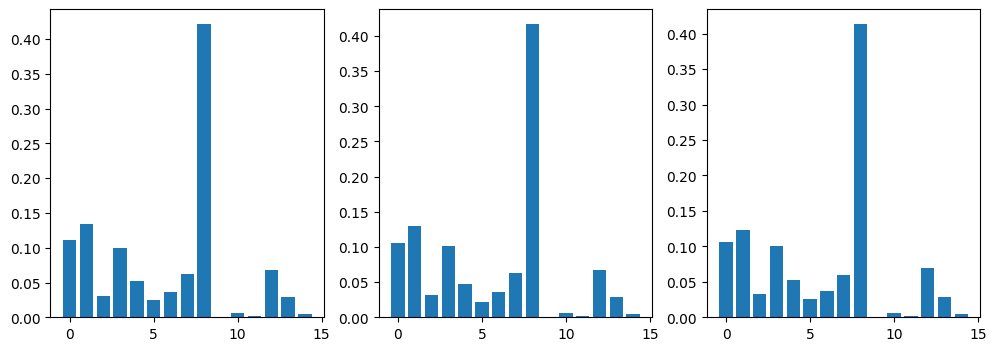

In [16]:
fig, ax = plt.subplots(1, 3, figsize=(12, 4))
i = 0
for split in [trainset, valset, testset]:
    meta = []
    meta_labels = 0
    for text, label, metadata in tqdm(split):
        meta.append(metadata)
        meta_labels += label
    meta = torch.stack(meta, dim=0)
    meta_labels = meta_labels / len(split)
    sum_meta = torch.sum(meta, dim=0)/len(split)
    ax[i].bar(range(15), sum_meta[:15])
    
    i += 1

In [17]:
from torch.utils.data import random_split
from torch.utils.data import Dataset
from typing import Tuple
def split_dataset(dataset: Dataset, lengths: list, random_seed: int = 57) -> Tuple[Dataset, Dataset]:
    return random_split(dataset, lengths,
                        generator=torch.Generator().manual_seed(random_seed))

In [18]:
new_trainset, id_val1, id_val2 = split_dataset(trainset, [0.8, 0.1, 0.1], random_seed=57)

In [19]:
from transformers import AutoModelForSequenceClassification, AutoTokenizer, AutoModel
%load_ext autoreload
%autoreload 2

In [20]:
model_name = "distilbert/distilbert-base-uncased-finetuned-sst-2-english"
tokenizer = AutoTokenizer.from_pretrained(model_name)
bert_model = AutoModel.from_pretrained(model_name).to('cuda:0')

In [56]:
texts = [
    "This is a terrible comment.",
    "Great insight, thanks for sharing!"
]

# Tokenize with padding/truncation
tokens = tokenizer(
    texts,
    padding=True,
    truncation=True,
    return_tensors="pt"
).to('cuda:0')

In [59]:
bert_model(**tokens).last_hidden_state.shape

torch.Size([2, 9, 768])

In [31]:
output = bert_model(**tokens)

In [7]:
trainloader = torch.utils.data.DataLoader(new_trainset, 64, num_workers=4)

In [13]:
batch = next(iter(trainloader))

In [22]:
tokenized_samples = []

for sample in tqdm(trainset):
    text = sample[0]  # assuming first item is the raw text
    tokens = tokenizer(text)  # works for HuggingFace tokenizers
    tokenized_samples.append(tokens)

  0%|          | 0/269038 [00:00<?, ?it/s]

KeyboardInterrupt: 